***Dependencies***

In [1]:
# !pip install gpytorch
# !pip install botorch
# !pip install matplotlib

In [2]:
"""Import Statements which we will need"""
from botorch.acquisition import ExpectedImprovement 
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.acquisition.objective import  IdentityMCObjective 
from botorch.exceptions import BadInitialCandidatesWarning
from botorch import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.optim.initializers import initialize_q_batch_nonneg
from botorch.sampling import SobolQMCNormalSampler 
from botorch.test_functions import Beale, Branin, Hartmann  
from botorch.utils import standardize, t_batch_mode_transform

from bo_helper_functions import (normalize, unnormalize, objective, get_random_observations, generate_initial_data,
                                 sigmoid, generate_cost, initialize_model, optimize_acqf_and_get_observation)
from eeipu_variants import EIPUVariants
  
from gpytorch.kernels import MaternKernel, LinearKernel, PiecewisePolynomialKernel, PolynomialKernel, RBFKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from matplotlib import pyplot as plt

import botorch 
import gpytorch 
import numpy as np
import os
import random
import torch
import warnings

## **1. Setup** 


In [3]:
'''Parameters for how the code runs
Note: true algorithm hyperparameters are defined in the main loop'''

# Add 5, asterisks `#*****`, to the end of any line we modified or added from -> ||  https://botorch.org/v/0.1.4/tutorials/closed_loop_botorch_only '''

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning) #*****

Text(0.5, 1.0, 'logistic function')

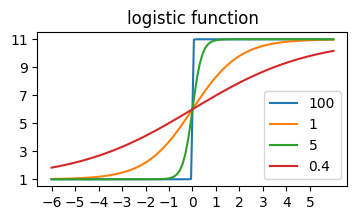

In [4]:
logistic = lambda z, const: 1./ (1 + np.exp(-const*z))       #logistic function
z = np.linspace(-6,6,100)
plt.subplots(1, 1, figsize=(4, 2))
plt.plot(z, logistic(z, 100)*10 + 1, label="100")
plt.plot(z, logistic(z, 1)*10 + 1, label="1")
plt.plot(z, logistic(z, 5)*10 + 1, label="5")
plt.plot(z, logistic(z, 0.4)*10 + 1, label="0.4")
plt.xticks(np.arange(-6,6,1))
plt.yticks(np.arange(1, 13, 2)) 
plt.legend(loc="lower right")

plt.title('logistic function')



## **2. Single BO Step**  

In [5]:
def single_bo_iteration(dataset={}, bounds={}, acq_type='', cfg={}):
    cost_model, cost_sampler={}, {}
    # (A) Normalize the dataset Points (only normalize cost if we are using acqfunc that needs cost model)
    # NOTE: single-line if statements used here
    if (cfg['normalize_bit']['x']==True and acq_type!='RAND'):
        train_x = normalize(dataset['x'], norm_type='x', bounds=bounds['x']) 
    else:
        train_x = dataset['x']
    if (cfg['normalize_bit']['y']==True and acq_type!='RAND'):
        train_obj = normalize(dataset['y'], norm_type='y', bounds=bounds['y'])   
    else:
        train_obj = dataset['y']
    if acq_type=='EEIPU': # cover potential cost model value normalisation
        if (cfg['normalize_bit']['c']==True and acq_type!='RAND'): 
            train_cost = normalize(dataset['c'], norm_type='c', bounds=bounds['c']) 
        else:
            train_cost = dataset['c']
    if acq_type=='EEIPU-INV': # cover potential inverse cost model value normalisation
        if (cfg['normalize_bit']['1/c'] and acq_type!='RAND'):
            train_cost = normalize(dataset['1/c'], norm_type='1/c', bounds=bounds['1/c'])  
        else:
            train_cost = dataset['1/c']

    # (B) Initialise/Re-initialize & Fit/Refit the GP models (only initialise cost model if we'll need it)
    mll, model= initialize_model(train_x, train_obj) 
    fit_gpytorch_model(mll);
    if acq_type in ['EEIPU', 'EEIPU-INV']: 
        cost_mll, cost_model= initialize_model(train_x, train_cost, cost_kernel=cfg['cost_kernel'])  
        fit_gpytorch_model(cost_mll)

    # (C) Redefine acquisition function & optimise  
    if (acq_type=='RAND'):
        acqf = 'RAND'
    elif (acq_type=='EI'):
        acqf = ExpectedImprovement(model=model, best_f=train_obj.max())
    elif (acq_type=='EIPU') or (acq_type=='EEIPU') or (acq_type=='EEIPU-INV'):
        cost_sampler = SobolQMCNormalSampler(num_samples=cfg['cost_samples'], resample=True, seed=cfg['rand_seed'])
        acqf = EIPUVariants(acq_type=acq_type, model=model, cost_model=cost_model, 
                 best_f=train_obj.max(), 
                 cost_sampler=cost_sampler, acq_objective=IdentityMCObjective(),   
                 cost_func=generate_cost, unnormalise_func=unnormalize, bounds=bounds,
                 cfg=cfg)
 
    if acq_type == 'RAND':
        new_x = optimize_acqf_and_get_observation(batch_size=cfg['batch_size'], acq_func=acq_type, 
                                              optim_bounds=bounds['x'], r_seed=cfg['rand_seed']) # includes random search option, for code neatness 
    else: # careful with bounds for non random acqfunctions - single line if statement used here
        normalised_bounds = normalize(bounds['x'], norm_type='x', bounds=bounds['x']) if cfg['normalize_bit']['x'] else bounds['x']  # Need too normalize the bounds used in the acqfunction too!
        new_x = optimize_acqf_and_get_observation(batch_size=cfg['batch_size'], acq_func=acqf,  # includes random search option, for code neatness 
                                            optim_bounds=normalised_bounds, r_seed=cfg['rand_seed'])
    # (D) Unnormalize the X value and return (also mc value since we can't compute outside this func)
    cost_model_mean = torch.tensor([0]); 
    if acq_type == 'EEIPU': cost_model_mean = acqf.compute_expected_cost(new_x)
    if acq_type == 'EEIPU-INV': cost_model_mean = acqf.direct_expected_inverse_cost(new_x)
    if cfg['normalize_bit']['x'] and acq_type != 'RAND' : new_x = unnormalize(new_x, norm_type='x', orig_bounds=bounds['x'])# cat with unnormalised x here
    return new_x, cost_model_mean.item()
   


## **3.0 BO Inner Loops (Multiple Steps)**  

In [6]:
def bo_inner_loops(trial_number=None, x_bounds=None, acq_type='', cfg={}):
    print(f"TRIAL #{trial_number} Acq-Type: [{acq_type}]")
    log_vals  = {'f(x^)': [],'x': [], 'f(x)': [], 'c(x)': [], 'mc(x)': [], '1/c(x)': [], 'c(c)':[]} # f(x^) = best obj val so far; c(c) is cumulative cost  

    dataset, bounds = {},{}
    # (A) Initialize dataset for all the different acq function types  
    dataset['x'], dataset['y'] = generate_initial_data(n=cfg['num_initial_data'], bounds=x_bounds, trial_seed=trial_number, cfg=cfg); 
    dataset['c'] = generate_cost(dataset['x'], cfg=cfg) 
    dataset['1/c'] = 1/dataset['c'] 

    log_vals['c(c)'].append(dataset['c'].sum().item())
    log_vals['f(x^)'].append(objective(dataset['x'], cfg=cfg).max().item())

    # (B) run N_ITERS rounds of BayesOpt after the initial random batch
    for iteration in range(cfg['n_iters']):    
        bounds['x'] = x_bounds # bounds written as min,max not max,min
        bounds['y'] = torch.tensor([[dataset['y'].min()], [dataset['y'].max()]], device=cfg['device'], dtype=cfg['dtype'])
        bounds['c'] = torch.tensor([[dataset['c'].min()], [dataset['c'].max()]], device=cfg['device'], dtype=cfg['dtype'])
        bounds['1/c'] = torch.tensor([[dataset['1/c'].min()], [dataset['1/c'].max()]], device=cfg['device'], dtype=cfg['dtype'])

        # (B.0) At each single iteration, we pass the dataset and take the next suggested point
        new_x, mc_x = single_bo_iteration(dataset=dataset, bounds=bounds, acq_type=acq_type, cfg=cfg )

        new_obj = objective(new_x, cfg=cfg).unsqueeze(-1)  # add output dimension 
        new_cost = generate_cost(new_x, cfg=cfg)  

        dataset['x'] = torch.cat([dataset['x'], new_x]) 
        dataset['y'] = torch.cat([dataset['y'], new_obj])  
        dataset['c'] = torch.cat([dataset['c'], new_cost])       
        dataset['1/c'] = torch.cat([dataset['1/c'], 1/new_cost])       

        log_vals['f(x^)'].append(objective(dataset['x'], cfg=cfg).max().item())
        log_vals['x'] = np.array(new_x.cpu())
        log_vals['f(x)'].append(new_obj.item())
        log_vals['c(x)'].append(new_cost.item())
        log_vals['c(c)'].append(log_vals['c(c)'][-1]+ new_cost.item())
        log_vals['mc(x)'] = mc_x
        log_vals['1/c(x)'].append((1/new_cost).item())

        if cfg['verbose']:
            print(f"Iteration-{iteration} [{acq_type}] Trial No. #{trial_number}"
              f"\nf(x^)={log_vals['f(x^)'][-1]:>4.3f}"
              f"\tf(x)={log_vals['f(x)'][-1]:>4.3f}"
              f"\tc(x) = {log_vals['c(x)'][-1]:>4.3f}"
              f"\tmc(x) = {log_vals['mc(x)']:>4.3f}" 
              f"\t1/c(x) = {log_vals['1/c(x)'][-1]:>4.3f}" 
              f"\tc(c) = {log_vals['c(c)'][-1]:>4.3f}")

    return log_vals

## **3.1. BO Outer Loops (Multiple Trials)**  

In [7]:
def bo_trials(cfg={}, acq_type=''):

    torch.manual_seed(seed=cfg['rand_seed'])
    np.random.seed(cfg['rand_seed'])
    random.seed(cfg['rand_seed'])
    botorch.utils.sampling.manual_seed(seed=cfg['rand_seed'])
    # https://github.com/pytorch/botorch/issues/371


    x_bounds = torch.tensor([[cfg['x_bounds'][0]] * cfg['fxn_dim'], [cfg['x_bounds'][1]] * cfg['fxn_dim']], device=cfg['device'], dtype=cfg['dtype'])
    log_vals_all  = {'f(x^)': [],'x': [], 'f(x)': [], 'c(x)': [], 'mc(x)': [], 'c(c)':[]}
    print("\n\nnormalize_bit", cfg['normalize_bit'])
    # average over multiple trials
    for trial in range(1, cfg['n_trials'] + 1):

        log_vals = bo_inner_loops(trial_number=trial, x_bounds=x_bounds, acq_type=acq_type, cfg=main_cfg)

        for key in log_vals_all.keys():
            log_vals_all[key].append(log_vals[key])
            if trial==cfg['n_trials']: log_vals_all[key] = np.array(log_vals_all[key])# save as np array on the last trial    
    return log_vals_all



## **3.2. BO Methods (Multiple Acquisitions)**  

In [8]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
2
0
NVIDIA GeForce RTX 2080 Ti


In [9]:
# Batch size in original tutorial meant q-batch size https://botorch.org/v/0.1.4/tutorials/closed_loop_botorch_only ||  # lower bound and upper bound could be -float('inf') ~ float('inf')
main_cfg = {
'batch_size':1, 'x_bounds': [-5,5],  
'CONSTANT':.5,
'cost_samples': 50, # mc cost samples
'cost_kernel': None, 
'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"), 'dtype': torch.double,
'fxn_name':'test', # {'test':3, 'branin_4d':4, 'beale_hartmann_7d':7,  'branin_hartmann_8d':8},   
'fxn_dim':3, # {'test':3, 'branin_4d':4, 'beale_hartmann_7d':7,  'branin_hartmann_8d':8},   
'neg_hartmann6':Hartmann(negate=True),
'neg_beale2':Beale(negate=True),
'neg_branin2':Branin(negate=True),
'neg_hartmann3':Hartmann(dim=3, negate=True), 
'n_trials':3,
'n_iters':30,
'num_initial_data':10,
'verbose':True,
'normalize_bit':{'x':True, 'y':True, 'c':True, '1/c':True}, 
'rand_seed': 0,
}
 
# (C) Do the above for each of the different acquisition function types
plot_vals = {}

plot_vals['RAND'] = bo_trials(cfg=main_cfg, acq_type='RAND') 
# plot_vals['RAND2'] = bo_trials(cfg=main_cfg, acq_type='RAND')  
plot_vals['EI'] = bo_trials(cfg=main_cfg, acq_type='EI') 
plot_vals['EIPU'] = bo_trials(cfg=main_cfg, acq_type='EIPU') 
plot_vals['EEIPU'] = bo_trials(cfg=main_cfg, acq_type='EEIPU') 
plot_vals['EEIPU-INV'] = bo_trials(cfg=main_cfg, acq_type='EEIPU-INV') 
# dfsdsdfsd




normalize_bit {'x': True, 'y': True, 'c': True, '1/c': True}
TRIAL #1 Acq-Type: [RAND]
Iteration-0 [RAND] Trial No. #1
f(x^)=-3.595	f(x)=-5.322	c(x) = 1.000	mc(x) = 0.000	1/c(x) = 1.000	c(c) = 76.106
Iteration-1 [RAND] Trial No. #1
f(x^)=-3.595	f(x)=-5.604	c(x) = 1.000	mc(x) = 0.000	1/c(x) = 1.000	c(c) = 77.106
Iteration-2 [RAND] Trial No. #1
f(x^)=-2.471	f(x)=-2.471	c(x) = 10.997	mc(x) = 0.000	1/c(x) = 0.091	c(c) = 88.103
Iteration-3 [RAND] Trial No. #1
f(x^)=-2.471	f(x)=-7.702	c(x) = 11.000	mc(x) = 0.000	1/c(x) = 0.091	c(c) = 99.103
Iteration-4 [RAND] Trial No. #1
f(x^)=-2.471	f(x)=-6.520	c(x) = 1.000	mc(x) = 0.000	1/c(x) = 1.000	c(c) = 100.103
Iteration-5 [RAND] Trial No. #1
f(x^)=-2.471	f(x)=-4.007	c(x) = 1.023	mc(x) = 0.000	1/c(x) = 0.977	c(c) = 101.126
Iteration-6 [RAND] Trial No. #1
f(x^)=-2.471	f(x)=-4.598	c(x) = 1.000	mc(x) = 0.000	1/c(x) = 1.000	c(c) = 102.126
Iteration-7 [RAND] Trial No. #1
f(x^)=-2.471	f(x)=-4.092	c(x) = 11.000	mc(x) = 0.000	1/c(x) = 0.091	c(c) = 113.126


Iteration-12 [RAND] Trial No. #3
f(x^)=-2.734	f(x)=-3.998	c(x) = 1.000	mc(x) = 0.000	1/c(x) = 1.000	c(c) = 128.166
Iteration-13 [RAND] Trial No. #3
f(x^)=-2.734	f(x)=-5.764	c(x) = 1.000	mc(x) = 0.000	1/c(x) = 1.000	c(c) = 129.166
Iteration-14 [RAND] Trial No. #3
f(x^)=-2.734	f(x)=-6.193	c(x) = 1.000	mc(x) = 0.000	1/c(x) = 1.000	c(c) = 130.166
Iteration-15 [RAND] Trial No. #3
f(x^)=-2.734	f(x)=-6.507	c(x) = 11.000	mc(x) = 0.000	1/c(x) = 0.091	c(c) = 141.166
Iteration-16 [RAND] Trial No. #3
f(x^)=-2.734	f(x)=-6.393	c(x) = 11.000	mc(x) = 0.000	1/c(x) = 0.091	c(c) = 152.166
Iteration-17 [RAND] Trial No. #3
f(x^)=-2.734	f(x)=-3.112	c(x) = 1.017	mc(x) = 0.000	1/c(x) = 0.984	c(c) = 153.183
Iteration-18 [RAND] Trial No. #3
f(x^)=-2.734	f(x)=-6.151	c(x) = 11.000	mc(x) = 0.000	1/c(x) = 0.091	c(c) = 164.183
Iteration-19 [RAND] Trial No. #3
f(x^)=-2.734	f(x)=-3.146	c(x) = 1.002	mc(x) = 0.000	1/c(x) = 0.998	c(c) = 165.185
Iteration-20 [RAND] Trial No. #3
f(x^)=-2.734	f(x)=-7.837	c(x) = 11.000	mc(x)

Iteration-24 [EI] Trial No. #2
f(x^)=-0.156	f(x)=-8.660	c(x) = 11.000	mc(x) = 0.000	1/c(x) = 0.091	c(c) = 234.637
Iteration-25 [EI] Trial No. #2
f(x^)=-0.156	f(x)=-5.642	c(x) = 1.000	mc(x) = 0.000	1/c(x) = 1.000	c(c) = 235.637
Iteration-26 [EI] Trial No. #2
f(x^)=-0.156	f(x)=-7.731	c(x) = 11.000	mc(x) = 0.000	1/c(x) = 0.091	c(c) = 246.637
Iteration-27 [EI] Trial No. #2
f(x^)=-0.156	f(x)=-4.147	c(x) = 4.698	mc(x) = 0.000	1/c(x) = 0.213	c(c) = 251.335
Iteration-28 [EI] Trial No. #2
f(x^)=-0.156	f(x)=-3.169	c(x) = 8.632	mc(x) = 0.000	1/c(x) = 0.116	c(c) = 259.966
Iteration-29 [EI] Trial No. #2
f(x^)=-0.156	f(x)=-0.942	c(x) = 1.120	mc(x) = 0.000	1/c(x) = 0.893	c(c) = 261.087
TRIAL #3 Acq-Type: [EI]
Iteration-0 [EI] Trial No. #3
f(x^)=-1.703	f(x)=-1.703	c(x) = 7.727	mc(x) = 0.000	1/c(x) = 0.129	c(c) = 75.536
Iteration-1 [EI] Trial No. #3
f(x^)=-0.945	f(x)=-0.945	c(x) = 8.593	mc(x) = 0.000	1/c(x) = 0.116	c(c) = 84.129
Iteration-2 [EI] Trial No. #3
f(x^)=-0.219	f(x)=-0.219	c(x) = 8.242	mc(x) 

Iteration-5 [EIPU] Trial No. #2
f(x^)=-1.005	f(x)=-1.274	c(x) = 1.177	mc(x) = 0.000	1/c(x) = 0.849	c(c) = 81.390
Iteration-6 [EIPU] Trial No. #2
f(x^)=-1.005	f(x)=-1.337	c(x) = 1.169	mc(x) = 0.000	1/c(x) = 0.856	c(c) = 82.559
Iteration-7 [EIPU] Trial No. #2
f(x^)=-0.767	f(x)=-0.767	c(x) = 1.220	mc(x) = 0.000	1/c(x) = 0.819	c(c) = 83.779
Iteration-8 [EIPU] Trial No. #2
f(x^)=-0.756	f(x)=-0.756	c(x) = 1.630	mc(x) = 0.000	1/c(x) = 0.613	c(c) = 85.410
Iteration-9 [EIPU] Trial No. #2
f(x^)=-0.756	f(x)=-1.273	c(x) = 1.055	mc(x) = 0.000	1/c(x) = 0.948	c(c) = 86.465
Iteration-10 [EIPU] Trial No. #2
f(x^)=-0.422	f(x)=-0.422	c(x) = 2.099	mc(x) = 0.000	1/c(x) = 0.476	c(c) = 88.564
Iteration-11 [EIPU] Trial No. #2
f(x^)=-0.163	f(x)=-0.163	c(x) = 4.790	mc(x) = 0.000	1/c(x) = 0.209	c(c) = 93.354
Iteration-12 [EIPU] Trial No. #2
f(x^)=-0.163	f(x)=-0.488	c(x) = 9.922	mc(x) = 0.000	1/c(x) = 0.101	c(c) = 103.276
Iteration-13 [EIPU] Trial No. #2
f(x^)=-0.163	f(x)=-0.448	c(x) = 5.229	mc(x) = 0.000	1/c(x) 

Iteration-16 [EEIPU] Trial No. #1
f(x^)=-0.314	f(x)=-7.979	c(x) = 11.000	mc(x) = 10.335	1/c(x) = 0.091	c(c) = 146.607
Iteration-17 [EEIPU] Trial No. #1
f(x^)=-0.314	f(x)=-1.353	c(x) = 10.737	mc(x) = 11.306	1/c(x) = 0.093	c(c) = 157.345
Iteration-18 [EEIPU] Trial No. #1
f(x^)=-0.314	f(x)=-4.798	c(x) = 1.000	mc(x) = 1.192	1/c(x) = 1.000	c(c) = 158.345
Iteration-19 [EEIPU] Trial No. #1
f(x^)=-0.314	f(x)=-5.751	c(x) = 1.000	mc(x) = 1.054	1/c(x) = 1.000	c(c) = 159.345
Iteration-20 [EEIPU] Trial No. #1
f(x^)=-0.314	f(x)=-0.753	c(x) = 7.290	mc(x) = 7.274	1/c(x) = 0.137	c(c) = 166.634
Iteration-21 [EEIPU] Trial No. #1
f(x^)=-0.314	f(x)=-1.638	c(x) = 1.005	mc(x) = 1.093	1/c(x) = 0.995	c(c) = 167.640
Iteration-22 [EEIPU] Trial No. #1
f(x^)=-0.314	f(x)=-7.731	c(x) = 11.000	mc(x) = 10.513	1/c(x) = 0.091	c(c) = 178.640
Iteration-23 [EEIPU] Trial No. #1
f(x^)=-0.314	f(x)=-5.023	c(x) = 10.989	mc(x) = 10.359	1/c(x) = 0.091	c(c) = 189.628
Iteration-24 [EEIPU] Trial No. #1
f(x^)=-0.314	f(x)=-7.105	c(x) 

Iteration-27 [EEIPU] Trial No. #3
f(x^)=-0.115	f(x)=-0.753	c(x) = 7.289	mc(x) = 7.258	1/c(x) = 0.137	c(c) = 192.368
Iteration-28 [EEIPU] Trial No. #3
f(x^)=-0.115	f(x)=-2.029	c(x) = 11.000	mc(x) = 10.765	1/c(x) = 0.091	c(c) = 203.367
Iteration-29 [EEIPU] Trial No. #3
f(x^)=-0.115	f(x)=-6.355	c(x) = 1.000	mc(x) = 1.257	1/c(x) = 1.000	c(c) = 204.367


normalize_bit {'x': True, 'y': True, 'c': True, '1/c': True}
TRIAL #1 Acq-Type: [EEIPU-INV]
Iteration-0 [EEIPU-INV] Trial No. #1
f(x^)=-3.595	f(x)=-4.504	c(x) = 1.002	mc(x) = 0.929	1/c(x) = 0.998	c(c) = 76.108
Iteration-1 [EEIPU-INV] Trial No. #1
f(x^)=-2.534	f(x)=-2.534	c(x) = 1.001	mc(x) = 0.950	1/c(x) = 0.999	c(c) = 77.109
Iteration-2 [EEIPU-INV] Trial No. #1
f(x^)=-2.159	f(x)=-2.159	c(x) = 1.001	mc(x) = 0.996	1/c(x) = 0.999	c(c) = 78.110
Iteration-3 [EEIPU-INV] Trial No. #1
f(x^)=-1.399	f(x)=-1.399	c(x) = 1.014	mc(x) = 0.882	1/c(x) = 0.986	c(c) = 79.124
Iteration-4 [EEIPU-INV] Trial No. #1
f(x^)=-0.903	f(x)=-0.903	c(x) = 1.230	mc(x) = 0

Iteration-5 [EEIPU-INV] Trial No. #3
f(x^)=-0.299	f(x)=-0.299	c(x) = 5.422	mc(x) = 0.229	1/c(x) = 0.184	c(c) = 80.675
Iteration-6 [EEIPU-INV] Trial No. #3
f(x^)=-0.192	f(x)=-0.192	c(x) = 6.865	mc(x) = 0.126	1/c(x) = 0.146	c(c) = 87.540
Iteration-7 [EEIPU-INV] Trial No. #3
f(x^)=-0.192	f(x)=-1.390	c(x) = 10.977	mc(x) = 0.220	1/c(x) = 0.091	c(c) = 98.517
Iteration-8 [EEIPU-INV] Trial No. #3
f(x^)=-0.192	f(x)=-0.287	c(x) = 8.048	mc(x) = 0.118	1/c(x) = 0.124	c(c) = 106.565
Iteration-9 [EEIPU-INV] Trial No. #3
f(x^)=-0.192	f(x)=-5.150	c(x) = 1.055	mc(x) = 0.860	1/c(x) = 0.948	c(c) = 107.620
Iteration-10 [EEIPU-INV] Trial No. #3
f(x^)=-0.192	f(x)=-0.557	c(x) = 8.459	mc(x) = 0.120	1/c(x) = 0.118	c(c) = 116.079
Iteration-11 [EEIPU-INV] Trial No. #3
f(x^)=-0.192	f(x)=-0.324	c(x) = 6.308	mc(x) = 0.159	1/c(x) = 0.159	c(c) = 122.386
Iteration-12 [EEIPU-INV] Trial No. #3
f(x^)=-0.192	f(x)=-8.660	c(x) = 1.000	mc(x) = 0.819	1/c(x) = 1.000	c(c) = 123.386
Iteration-13 [EEIPU-INV] Trial No. #3
f(x^)=-0.

## **4.0. Plotting and Value Analyses**  

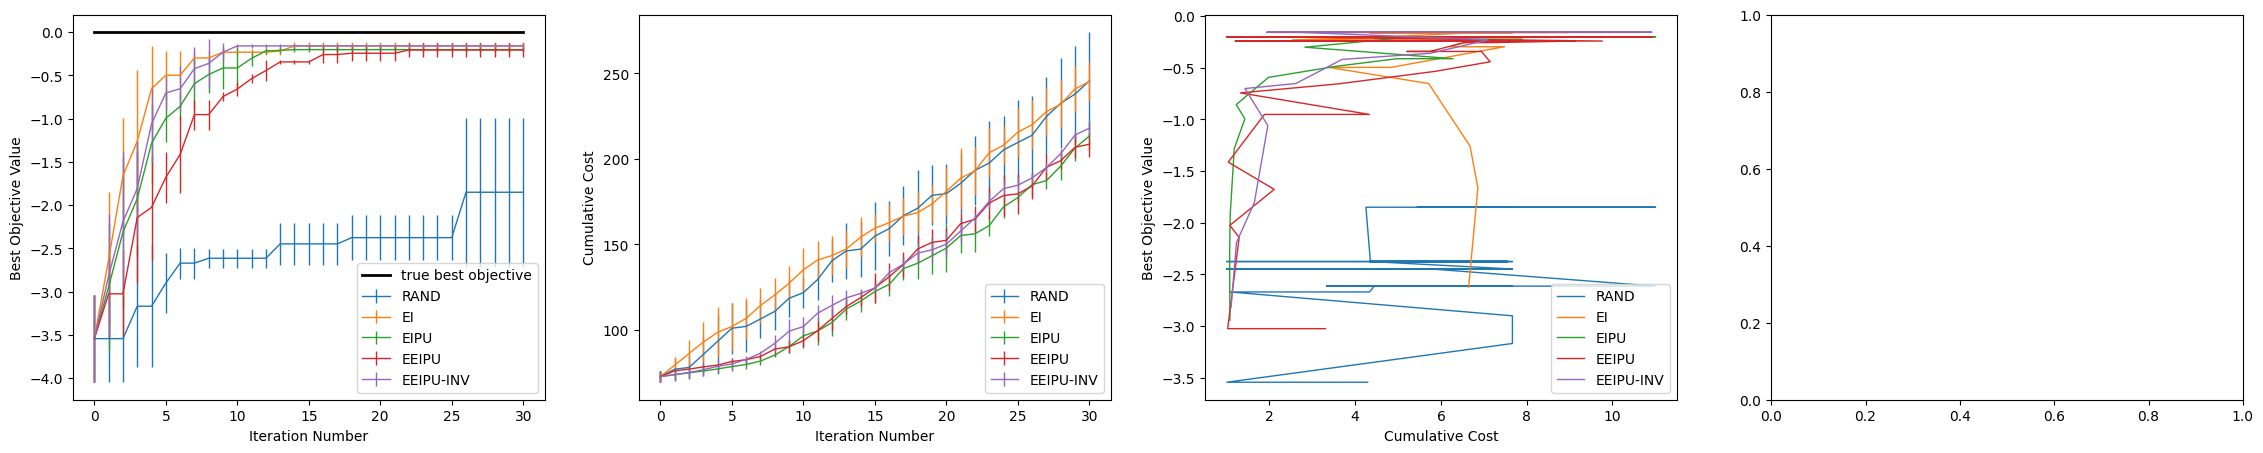

In [10]:
# from botorch.test_functions.hartmann6 import GLOBAL_MAXIMUM

%matplotlib inline
def ci(y):
    # return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)
    return y.std(axis=0) 

# GLOBAL_MAXIMUM = 3.32237
GLOBAL_MAXIMUM = 0
iters = np.arange(main_cfg['n_iters']+1) * main_cfg['batch_size']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(28, 5))

ax1.plot([0, main_cfg['n_iters'] * main_cfg['batch_size'] ], [GLOBAL_MAXIMUM] * 2, 'k', label="true best objective", linewidth=2)

types = ['RAND', 'EI', 'EIPU','EEIPU','EEIPU-INV',] 
 
for type_ in types:
    ax1.errorbar(iters, plot_vals[type_]['f(x^)'].mean(axis=0), 
               yerr=ci(plot_vals[type_]['f(x^)']), label=type_, linewidth=1) 
    # Can exclude cumumulative cost of random warmup points using `[:,1:]`, of course
    ax2.errorbar(iters, plot_vals[type_]['c(c)'].mean(axis=0), 
               yerr=ci(plot_vals[type_]['c(c)']), label=type_, linewidth=1) 
    ax3.plot(plot_vals[type_]['c(x)'].mean(axis=0), plot_vals[type_]['f(x^)'][:,1:].mean(axis=0), 
              label=type_, linewidth=1) 
    ### Use this to replace error bars with fill
    # ax3.fill_between(cum_cost_ei.mean(axis=0), y1=y_ei.mean(axis=0)-y_ei.std(axis=0), y2=y_ei.mean(axis=0)+y_ei.std(axis=0), label="EI", alpha=.5, linewidth=0)
    # ax1.set_xlim(right=20); # ax1.set_ylim(bottom=0.5); 

ax1.set(xlabel='Iteration Number', ylabel='Best Objective Value')
ax1.legend(loc="lower right")
ax2.set(xlabel='Iteration Number', ylabel='Cumulative Cost')
ax2.legend(loc="lower right")  
ax3.set(xlabel='Cumulative Cost', ylabel='Best Objective Value')
ax3.legend(loc="lower right") 
 